In [1]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")
include("LagF.jl")

LagF (generic function with 1 method)

In [2]:
# Forward Euler method to store porovisional Solution
function FE(f, tspan, y0, N)
    
    y=zeros(N+1)
    h=(tspan[2]-tspan[1])/ N
    t=Vector(range(tspan[1], tspan[2], N+1))
    y[1]=y0
    for i in 1:N
        y[i+1] = y[i] .+ h*f(t[i], y[i])
    end
    return t, y
end

FE (generic function with 1 method)

In [3]:
# Two-step Adams Bashforth Scheme (Explicit)

function ab2(f, tspan, y0, N)
    h = (tspan[2] - tspan[1]) / N
    t = Vector(range(tspan[1], tspan[2], length=N+1))
    y = zeros(N + 1, 1)
    y[1] = y0
    k1=h*f(t[1], y[1])
    k2=h*f(t[1]+h, y[1]+k1)
    y[2]=y[1]+0.5*(k1+k2)
    # Two -step AB steps
    for i in 1:(N-1)
        y[i + 2] = y[i + 1] + (3/2) *h* f(t[i+1], y[i+1]) - 0.5 *h* f(t[i], y[i])
    end

    return t, y
end

ab2 (generic function with 1 method)

# RIDC5 with FE predictor and 2 corrections with AB-2

In [4]:
function ridc5_feab2(f, tspan, y0 , N)
    
 
    K = 2
    
    h = (tspan[2] - tspan[1]) / N
    
    # Embedding AB-2 into RIDC
    # AB-2 update takes the form 
    # y_(n+1)= y_n + (3/2)*h*f(t_n, y_n) - (1/2)*h*f(t_(n-1), y_(n-1)).
    
    y=zeros(1, N+1, K+1)
    
    t, y[1, :, 1]= FE(f, tspan, y0, N) # storing the provisional solution
   
   for k in 1:K
        y[1, 1, k+1]=y0 # initial condition
        nfval=f(t, y[1, :, k]) # New function value
        
        # (2k+1) equi-spaced nodes are used where k is the iteration number. 
        
        # First step computed by Trapezoidal RK2 (Explicit)
        Qdr=Lagrange(t[1:(2*k+1)], nfval[1:(2*k+1)], t[1], t[2]) # Quadrature
        k1= h*(f(t[1], y[1, 1, k+1])- f(t[1], y[1, 1, k]))
        k2= h*(f(t[1] + h, y[1, 1, k+1] + k1 + Qdr) - f(t[1]+h, y[1, 2, k])) 
        
        y[1, 2, k+1]=y[1, 1, k+1] + k1/2 + k2/2 + Qdr
        
        
        
        # First nth steps
        for n in 3:(2*k+1)
            Q= Lagrange(t[1:(2*k+1)], nfval[1:(2*k+1)], t[n-1], t[n])
            b1= (3/2)* h*(f(t[n-1], y[1, n-1, k+1]) - f(t[n-1], y[1, n-1, k]))
            b2= (1/2)* h*(f(t[n-2], y[1, n-2, k+1]) - f(t[n-2], y[1, n-2, k]))
            y[1, n, k+1]= y[1, n-1, k+1] + b1 - b2 + Q
        end
        
        for j in (2*k+2):(N+1)
            Q = Lagrange(t[j-(2*k+1):j-1], nfval[j-(2*k+1):j-1], t[j-1], t[j])
            b1= (3/2)* h*(f(t[j-1], y[1, j-1, k+1]) - f(t[j-1], y[1, j-1, k]))
            b2= (1/2)* h*(f(t[j-2], y[1, j-2, k+1]) - f(t[j-2], y[1, j-2, k]))
            y[1, j, k+1]= y[1, j-1, k+1] + b1 - b2 + Q
        end
            
    end
    return y[1, N+1, K+1]
end

ridc5_feab2 (generic function with 1 method)

 N=5, p= 4.0826883258632245
 N=10, p= 4.218868456808917
 N=15, p= 4.426113795519953
 N=20, p= 4.64382668869515
 N=25, p= 4.79324288369943
 N=30, p= 4.879450882758744
 N=35, p= 4.859894801732976
 N=40, p= 4.093352221161008


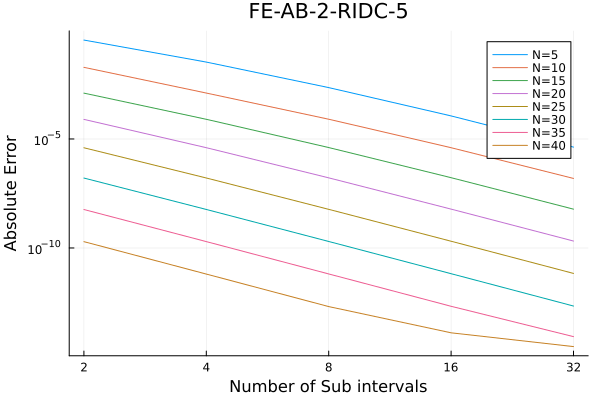

In [5]:
# Example : y'= , y(0)=1; T in [0, T]

using Plots

y0=1.0


tspan=[0 11]


f(t, y)= - y .^3



# Exact Solution

exact = 1/sqrt(1+2tspan[2])

p=8 # Parameter for various N values

q=5 # subinterval varying parameter

err = zeros(p, q)

nsub=zeros(q)

nval=zeros(p)

for n=1:p
    
    N= 5*2^(n-1)

    
    nval[n]= N # store N's
    
    for j= 1:q
        
        sub = 2^j # Number of subinterval
        
        nsub[j]= sub # store subinterval
    
        ds = tspan[2] / sub # final time / # of subinterval (I fixed here after Tuesday's meeting)

        
        y=y0
        
        for i in 1:sub
    
            t0 = (i - 1) * ds # initial time
            tf = i * ds   # final time
            
            y = ridc5_feab2(f, [t0 tf], y, N)

        end
        
        err[n, j] = abs(exact - y)
        
    end
    
end


plot(nsub, err[1, :], xaxis=:log, yaxis=:log,  label="N=$(5 * 1)", ylabel="Absolute Error",xticks=nsub, xformatter=x -> string(Int(round(x))))
pdeg = polyfit(log10.(nsub[:]), log10.(err[1,:]),1)
print(" N=$(5 * 1), p= ", abs(pdeg[2]),"\n")
for l in 2:p
    plot!(nsub, err[l, :], xaxis=:log, yaxis=:log,  label="N=$(5* l)", xlabel="Number of Sub intervals", ylabel="Absolute Error", title="FE-AB-2-RIDC-5", xticks=nsub, xformatter=x -> string(Int(round(x))))
    pdeg = polyfit(log10.(nsub[:]), log10.(err[l,:]),1)
    print(" N=$(5 * l), p= ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

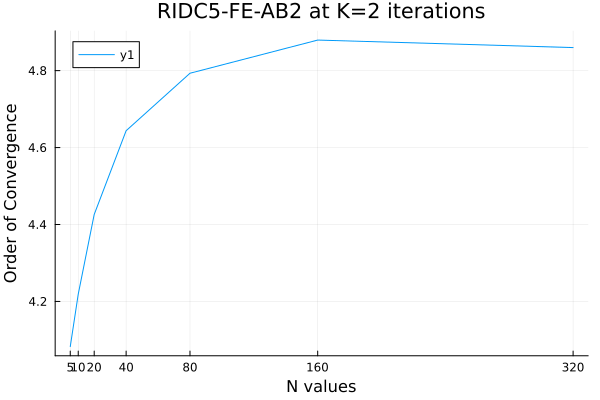

In [6]:
order=zeros(p)
for i=1:p
    pdeg = polyfit(log10.(nsub[:]), log10.(err[i,:]),1)
    order[i]=abs(pdeg[2])
end
plot(nval[1:end-1], order[1:end-1], xlabel="N values", ylabel="Order of Convergence", title="RIDC5-FE-AB2 at K=2 iterations", xticks=nval)

 N=5, p= 4.063330797067054
 N=10, p= 4.359309059109261
 N=15, p= 4.660033867696357
 N=20, p= 4.830763864389736
 N=25, p= 4.92098423627842
 N=30, p= 4.9926087725171895
 N=35, p= 4.879452435791062


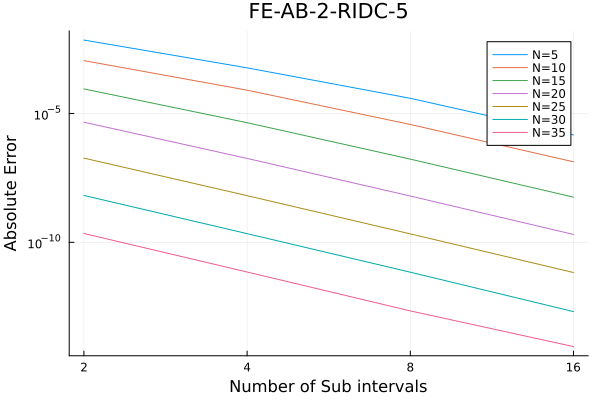

In [7]:
# Example : y'= , y(0)=1; T in [0, T]

using Plots

y0=1.0


tspan=[0 2]


f(t, y)= t .* y.^2 .* cos.(t) .^2



# Exact Solution

exact2= -8 /(-9 + 2* tspan[2]^2 + cos(2*tspan[2]) + 2* tspan[2] * sin(2*tspan[2])) 

p=7 # Parameter for various N values

q=4 # subinterval varying parameter

err2 = zeros(p, q)

nsub=zeros(q)

nval=zeros(p)

for n=1:p
    
    N= 5*2^(n-1)

    
    nval[n]= N # store N's
    
    for j= 1:q
        
        sub = 2^j # Number of subinterval
        
        nsub[j]= sub # store subinterval
    
        ds = tspan[2] / sub # final time / # of subinterval (I fixed here after Tuesday's meeting)

        
        y=y0
        
        for i in 1:sub
    
            t0 = (i - 1) * ds # initial time
            tf = i * ds   # final time
            
            y = ridc5_feab2(f, [t0 tf], y, N)

        end
        
        err2[n, j] = abs(exact2 - y)
        
    end
    
end


plot(nsub, err2[1, :], xaxis=:log, yaxis=:log,  label="N=$(5 * 1)", ylabel="Absolute Error",xticks=nsub, xformatter=x -> string(Int(round(x))))
pdeg = polyfit(log10.(nsub[:]), log10.(err2[1,:]),1)
print(" N=$(5 * 1), p= ", abs(pdeg[2]),"\n")
for l in 2:p
    plot!(nsub, err2[l, :], xaxis=:log, yaxis=:log,  label="N=$(5* l)", xlabel="Number of Sub intervals", ylabel="Absolute Error", title="FE-AB-2-RIDC-5", xticks=nsub, xformatter=x -> string(Int(round(x))))
    pdeg = polyfit(log10.(nsub[:]), log10.(err2[l,:]),1)
    print(" N=$(5 * l), p= ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

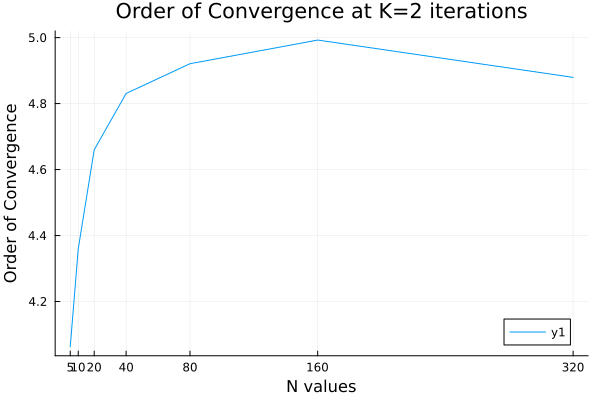

In [8]:
order2=zeros(p)
for i=1:p
    pdeg = polyfit(log10.(nsub[:]), log10.(err2[i,:]),1)
    order2[i]=abs(pdeg[2])
end
plot(nval[1:end], order2[1:end], xlabel="N values", ylabel="Order of Convergence", title="Order of Convergence at K=2 iterations", xticks=nval)

# RIDC5 with AB-2 predictor and one correction with AB-3

In [9]:
function ridc5_ab23(f, tspan, y0 , N)
    
 
    K = 1
    
    h = (tspan[2] - tspan[1]) / N
    
    # Embedding AB-2 and AB-3 into RIDC
    
    
    y=zeros(1, N+1, K+1)
    
    t, y[1, :, 1]= ab2(f, tspan, y0, N) # storing the provisional solution
   
   for k in 1:K
        
        y[1, 1, k+1]=y0 # initial condition
        
        nfval=f(t, y[1, :, k]) # New function value
        
        # (4k+1) equi-spaced nodes are used where k is the iteration number. 
        
         # First few steps computed by Trapezoidal RK3 (Explicit)
        
       #for i=1:2
            
            #Q1= Lagrange(t[1:5], nfval[1:5], t[i], t[i]+ 0.5*h)
            
           #Q2 = Lagrange(t[1:5], nfval[1:5], t[i], t[i+1])
            
            #yhalf = LagF(t[1:5], nfval[1:5], t[i]+ 0.5*h) # Approximating f(t_m+c2*h, y(t_m+c2*h))
            
            #k1= h*(f(t[i], y[1, i, k+1]) - f(t[i], y[1, i, k]))
            
            #k2= h*(f(t[i]+0.5*h, y[1, i, k+1] + 0.5*k1 + Q1) - yhalf)
            
            #k3= h*(f(t[i]+h, y[1, i, k+1] - k1 + 2*k2 + Q2) - f(t[i]+h, y[1, i+1, k]))
            
            #y[1, i+1, k+1]= y[1, i, k+1]+ (1/6)*k1 + (2/3)*k2 +(1/6)*k3 + Q2
        #end
        
        
        # First few steps computed by Trapezoidal RK2 (Explicit)
        #for i=2:2
            #Qdr=Lagrange(t[1:(4*k+1)], nfval[1:(4*k+1)], t[i-1], t[i]) # Quadrature
            #k1= h*(f(t[i-1], y[1, i-1, k+1])- f(t[i-1], y[1, i-1, k]))
            #k2= h*(f(t[i-1] + h, y[1, i-1, k+1] + k1 + Qdr) - f(t[i-1]+h, y[1, i, k]))
            #y[1, i, k+1]=y[1, i-1, k+1] + k1/2 + k2/2 + Qdr
        #end
        
        
        # Exact starting conditions
        
        y[1, 2, k+1]= -8 /(-9 + 2* t[2]^2 + cos(2*t[2]) + 2* t[2] * sin(2*t[2])) 
        y[1, 3, k+1]= -8 /(-9 + 2* t[3]^2 + cos(2*t[3]) + 2* t[3] * sin(2*t[3])) 
        
        # First nth steps
        for n in 4:(3*k+2)
            Q= Lagrange(t[1:(4*k+1)], nfval[1:(4*k+1)], t[n-1], t[n])
            b1= (23/12)* h*(f(t[n-1], y[1, n-1, k+1]) - f(t[n-1], y[1, n-1, k]))
            b2= (16/12)* h*(f(t[n-2], y[1, n-2, k+1]) - f(t[n-2], y[1, n-2, k]))
            b3= (5/12)* h*(f(t[n-3], y[1, n-3, k+1]) - f(t[n-3], y[1, n-3, k]))
            y[1, n, k+1]= y[1, n-1, k+1] + b1 - b2 + b3 + Q
        end
        
        for j in (4*k+2):(N+1)
            Q = Lagrange(t[j-(4*k+1):j-1], nfval[j-(4*k+1):j-1], t[j-1], t[j])
            b1= (23/12)* h*(f(t[j-1], y[1, j-1, k+1]) - f(t[j-1], y[1, j-1, k]))
            b2= (16/12)* h*(f(t[j-2], y[1, j-2, k+1]) - f(t[j-2], y[1, j-2, k]))
            b3= (5/12)* h*(f(t[j-3], y[1, j-3, k+1]) - f(t[j-3], y[1, j-3, k]))
            y[1, j, k+1]= y[1, j-1, k+1] + b1 - b2 + b3 + Q
        end
            
    end
    return y[1, N+1, K+1]
end

ridc5_ab23 (generic function with 1 method)

 N=5, p= 3.756922501166688
 N=10, p= 4.1333200361097004
 N=15, p= 4.551377237085892
 N=20, p= 4.810829106098426
 N=25, p= 4.9642065006694756
 N=30, p= 5.0747045114333655
 N=35, p= 5.1897704450929725


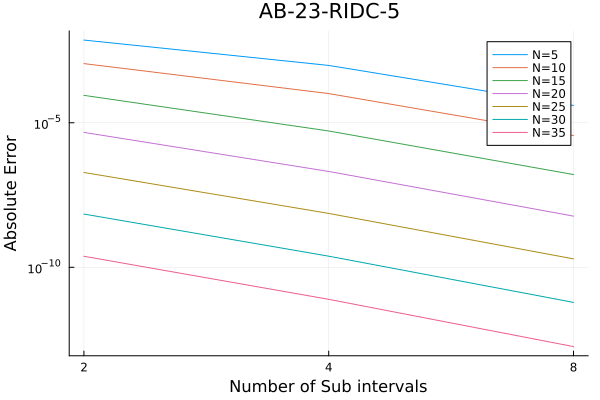

In [10]:
# Example : y'= , y(0)=1; T in [0, T]

using Plots

y0=1.0


tspan=[0 2]


f(t, y)= t .* y.^2 .* cos.(t) .^2



# Exact Solution

exact2= -8 /(-9 + 2* tspan[2]^2 + cos(2*tspan[2]) + 2* tspan[2] * sin(2*tspan[2])) 

p=7 # Parameter for various N values

q=3 # subinterval varying parameter

err3 = zeros(p, q)

nsub=zeros(q)

nval=zeros(p)

for n=1:p
    
    N= 5*2^(n-1)
    #N=5*n
    
    nval[n]= N # store N's
    
    for j= 1:q
        
        sub = 2^j # Number of subinterval
        
        nsub[j]= sub # store subinterval
    
        ds = tspan[2] / sub # final time / # of subinterval (I fixed here after Tuesday's meeting)

        
        y=y0
        
        for i in 1:sub
    
            t0 = (i - 1) * ds # initial time
            tf = i * ds   # final time
            
            y = ridc5_ab23(f, [t0 tf], y, N)

        end
        
        err3[n, j] = abs(exact2 - y)
        
    end
    
end


plot(nsub, err3[1, :], xaxis=:log, yaxis=:log,  label="N=$(5 * 1)", ylabel="Absolute Error",xticks=nsub, xformatter=x -> string(Int(round(x))))
pdeg = polyfit(log10.(nsub[:]), log10.(err3[1,:]),1)
print(" N=$(5 * 1), p= ", abs(pdeg[2]),"\n")
for l in 2:p
    plot!(nsub, err3[l, :], xaxis=:log, yaxis=:log,  label="N=$(5* l)", xlabel="Number of Sub intervals", ylabel="Absolute Error", title="AB-23-RIDC-5", xticks=nsub, xformatter=x -> string(Int(round(x))))
    pdeg = polyfit(log10.(nsub[:]), log10.(err3[l,:]),1)
    print(" N=$(5 * l), p= ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

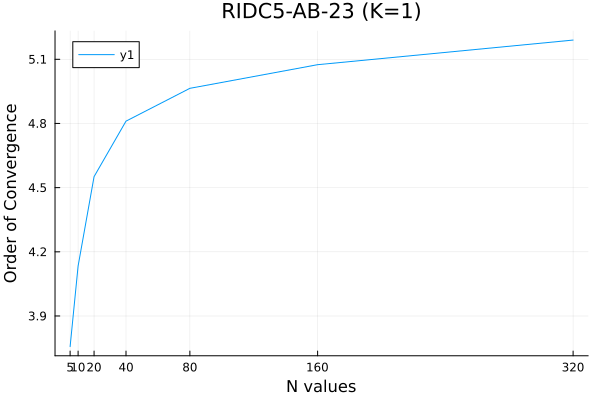

In [11]:
order3=zeros(p)
for i=1:p
    pdeg = polyfit(log10.(nsub[:]), log10.(err3[i,:]),1)
    order3[i]=abs(pdeg[2])
end
plot(nval, order3, xlabel="N values", ylabel="Order of Convergence", title="RIDC5-AB-23 (K=1)", xticks=nval)